# LCD-Task: Training of an SNN Demapper with Receptive-field Encoding

In this example we train SNN-based demapp with a single hidden LIF layer and a non-spiking leaky-integrator voting layer to solve the LCD-Task [1]. We investigate the impact of noise-level $\sigma$, the size of the hidden layer and the number of $n_\text{taps}$ used.
The SNN demapper used in this example is based on [2].


### References
[1] Elias Arnold, Eike-Manuel Edelmann, Alexander von Bank, Eric Müller, Laurent Schmalen, Johannes Schemmel, Short-reach Optical Communications: A Real-world Task for Neuromorphic Hardware. [https://arxiv.org/abs/2412.03129](https://arxiv.org/abs/2412.03129)

[2] Elias Arnold, Georg Böcherer, Florian Strasser, Eric Müller, Philipp Spilger, Sebastian Billaudelle, Johannes Weis, Johannes Schemmel, Stefano Calabrò, Maxim Kuschnerov, “Spiking neural network nonlinear
demapping on neuromorphic hardware for IM/DD optical communication. [https://ieeexplore.ieee.org/abstract/document/10059327/](https://ieeexplore.ieee.org/abstract/document/10059327/).


In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch
import norse.torch as norse

from IMDD import LCDDataset, helpers

## Receptive-field Encoding

One question when training a spiking demapper is how to best translate a chunk of real-valued data into a spiking representation in an efficient way.
The receptive-field encoding translates each samples $y[k]$ in the chunk to a set of $P$ spiking neurons.
Each neuron has a `reference_point` assigned and its spike time is determined by the distance of $y[k]$ to the given reference value.
This results in a spatio-temporal encoding with $P$ neurons per sample $k$, so $n_\text{tap}\cdot P$ input neurons as detailed in [2].

We first create implement the encoder as defined in [2]:

In [2]:
class ReceptiveFieldEncoder(torch.nn.Module):

    def __init__(self, scaling: float, offset: float, time_length: float,
                 dt: float, references: torch.Tensor, cutoff: float = None):
        super().__init__()
        self.scaling = scaling
        self.offset = offset
        self.time_length = time_length
        self.dt = dt
        self.time_steps = int(time_length // dt) + 1
        self.references = references
        self.cutoff = cutoff if cutoff is not None else time_length

    def forward(self, trace: torch.Tensor) -> torch.Tensor:
        dev = trace.device

        # positive spike times
        times = self.scaling * torch.abs(
            trace.unsqueeze(-1) - self.references.to(dev)).reshape(
                trace.shape[0], -1)

        times[(times < 0) | (times > self.cutoff)] = self.time_length + self.dt
        times += self.offset

        bins = (times / self.dt + 1).long()
        mask = bins < self.time_steps
        mesh = torch.meshgrid([torch.arange(s) for s in times.shape], indexing="ij")

        indices = torch.stack(
            (bins.to(dev)[mask].reshape(-1),
             mesh[0].to(dev)[mask].reshape(-1),
             *(mesh[i].to(dev)[mask].reshape(-1)
               for i in range(1, len(mesh)))))

        spikes = torch.sparse_coo_tensor(
            indices, torch.ones(indices.shape[1]).to(dev),
            (self.time_steps, times.shape[0], *times.shape[1:]), dtype=int)

        return spikes.to_dense()

Next we create the dataset and visualize the input encoding.

In [3]:
dataset = LCDDataset(train=True)

# Generate some data
y_chunk, q = dataset[45]

# Data
print("Received symbols y (chunked):\n\t", y_chunk, y_chunk.shape)
print("Corresponding index q:\n\t", q, q.shape)
print("Corresponding send bits:\n\t", helpers.get_graylabel(2)[q])

Received symbols y (chunked):
	 tensor([1.3812, 4.9241, 4.5746, 4.9569, 2.6475, 3.4541, 2.3222]) torch.Size([7])
Corresponding index q:
	 tensor(3) torch.Size([])
Corresponding send bits:
	 tensor([1, 0], dtype=torch.uint8)


Next, we create an instance of the `ReceptiveFieldEncoder`. The encoding is defined by the `references` which we choose to be $10$ values equdistantly distributed in $[0, 7]$. The distance $y_k - \chi_i$ is scaled by `scaling`. We neglect spikes which are later than `cutoff`.

In [4]:
P = 10
references = torch.linspace(0, 7, P)
print("References:\n", references)

# Temporal resolution of encoding and SNN
dt = 5e-4
time_length = 0.03 # s
cutoff = 0.015 # s
offset = 0

# The encoder
encoder = ReceptiveFieldEncoder(
    scaling=0.008,
    offset=offset,
    time_length=time_length,
    dt=dt,
    references=references,
    cutoff=cutoff)
encoder

References:
 tensor([0.0000, 0.7778, 1.5556, 2.3333, 3.1111, 3.8889, 4.6667, 5.4444, 6.2222,
        7.0000])


ReceptiveFieldEncoder()

Now we encode `y_chunk` into a binary spike tensor. The first dimension in the resulting data is the time axis, which is 60, corresponding to 30 ms. This becomes clearer in the plot below.

In [5]:
spikes = encoder(y_chunk.unsqueeze(0))  # add batch dim
print("Spikes:\n", spikes, spikes.shape)

Spikes:
 tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]]) torch.Size([60, 1, 70])


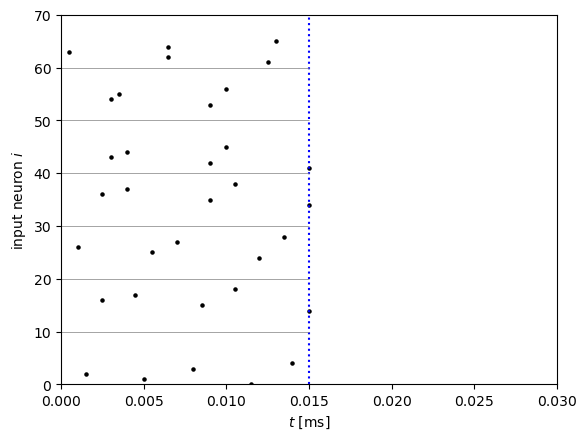

In [6]:
# Convert time-dense spikes into event-based spikes
events = torch.nonzero(spikes[:, 0])
time = np.linspace(0, time_length, int(time_length / dt))

fig, axes = plt.subplots(1)
axes.set_xlim(0, time_length)
axes.set_ylim(0, dataset.simulator.params.n_taps * P)
axes.set_xlabel("$t$ [ms]")
axes.set_ylabel("input neuron $i$")
axes.scatter(events[:, 0] * dt, events[:, 1], s=5, color="black")
axes.vlines(cutoff + offset, 0, dataset.simulator.params.n_taps * P, color="blue", ls=":")
for i in range(7):
    axes.hlines(10 * (i + 1), 0, cutoff + offset, color="grey", lw=0.5)
plt.show()

# Model

Now we define a SNN which we train to solve the demapping task.

In [7]:
class SNNDemapper(torch.nn.Module):
    """ SNN Demapper consiting of a single hidden LIF layer and LI readout layer """
    def __init__(self,
                 n_in: int,
                 n_hidden: int,
                 n_out: int,
                 encoder: torch.nn.Module,
                 lif_params: norse.LIFParameters,
                 li_params: norse.LIParameters,
                 dt: float,
                 device: torch.device):
        super().__init__()
        self.device = device

        self.dt = dt
        # Regularization
        self.reg_bursts = 0.0005
        self.reg_weight_1 = 0.0001
        self.reg_weight_2 = 0.0001
        self.reg_readout = 0.0
        self.target_rate = 0.5

        # Encoding symbols to spikes
        self.encoder = encoder

        # SNN
        self.linear_1 = torch.nn.Linear(n_in, n_hidden, device=device, bias=None)
        self.lif = norse.LIFCell(lif_params)
        self.linear_2 = torch.nn.Linear(n_hidden, n_out, device=device, bias=None)
        self.li = norse.LICell(li_params)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        self.zi = self.encoder(input).float()

        T = self.zi.shape[0]
        s_lif, s_li = None, None
        zs, ys, s_lifs, s_lis = [], [], [], []
        for ts in range(T):
            g1 = self.linear_1(self.zi[ts])
            z, s_lif = self.lif(g1, s_lif)
            g2 = self.linear_2(z)
            y, s_li = self.li(g2, s_li)

            zs.append(z)
            ys.append(y)
            s_lifs.append(s_lif)
            s_lis.append(s_li)

        self.spikes = torch.stack(zs)
        self.traces = torch.stack(ys)
        self.v_lif = torch.stack([s.v for s in s_lifs])

        self.score = torch.amax(self.traces, 0)

        return self.score

    @property
    def rate(self) -> torch.tensor:
        return self.zi.sum(0).sum(1), self.spikes.sum(0).sum(1)

    def regularize(self) -> torch.Tensor:
        """ Regularization terms for demapper """
        reg = torch.tensor(0.).to(self.device)
        # Regularize linear weights
        reg += self.reg_weight_1 * torch.mean(self.linear_1.weight ** 2)
        reg += self.reg_weight_2 * torch.mean(self.linear_2.weight ** 2)
        # Regularize firing rates
        reg += self.reg_bursts * (
            (self.target_rate - self.spikes.sum(0)).mean(0) ** 2).mean()
        # Regularize readout traces
        reg += self.reg_readout * torch.mean(torch.max(self.traces, 0)[0] ** 2)
        return reg

# Helper functions

In [8]:
# Some functions for training and testing

def stats(loss: torch.Tensor, pred: torch.Tensor, data: torch.Tensor):
    ber = helpers.bit_error_rate(data, pred, False)
    acc = helpers.accuracy(data, pred, False)
    
    # Number false bits in current batch
    count = torch.count_nonzero(
        (gray_bits[torch.argmax(pred, 1)] != gray_bits[data]).reshape(-1))

    return ber, acc, count


def train(dataloader, optimizer, scheduler, loss_fn, demapper, device):
    loss, acc, ber = [], [], []
    demapper.train()

    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)

        pred_b = demapper(data)
        loss_b = loss_fn(pred_b, target)
        # regularization
        loss_b += demapper.regularize()

        # Optimize
        loss_b.backward()
        optimizer.step()

        # Get stats
        ber_b, acc_b, _ = stats(loss_b, pred_b, target)

        # Accumualte
        loss.append(loss_b.detach())
        acc.append(acc_b)
        ber.append(ber_b)

    scheduler.step()

    return (torch.stack(loss).reshape(-1).mean(),
            torch.stack(acc).reshape(-1).mean(),
            torch.stack(ber).reshape(-1).mean())


def validate(dataloader, demapper, loss_fn, device, min_false_bits, max_test_epochs):
    loss, acc, ber, n_false = [], [], [], 0
    demapper.eval()

    for epoch in range(max_test_epochs):
        for i, (data, target) in enumerate(dataloader):

            data = data.to(device)
            target = target.to(device)

            pred_b = demapper(data)
            loss_b = loss_fn(pred_b, target)
            loss_b += demapper.regularize()

            ber_b, acc_b, count = stats(loss_b, pred_b, target)

            loss.append(loss_b.detach())
            acc.append(acc_b)
            ber.append(ber_b)

            n_false += count

        if n_false >= min_false_bits:
            break

    return (torch.stack(loss).reshape(-1).mean(),
            torch.stack(acc).reshape(-1).mean(),
            torch.stack(ber).reshape(-1).mean(), n_false)


def test(dataloader, demapper, device, min_false_bits):
    ber, i_rate, h_rate, n_false = [], [], [], 0
    while True:
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            pred_b = lif_demapper(data)

            ber_b = helpers.bit_error_rate(target, pred_b, False)
            ber.append(ber_b)

            i_rate.append(lif_demapper.rate[0].detach())
            h_rate.append(lif_demapper.rate[1].detach())

            # Number false bits in current batch
            n_false += torch.count_nonzero(
                (gray_bits[torch.argmax(pred_b, 1)] != gray_bits[target]).reshape(-1))

        if n_false >= min_false_bits:
            break
    
    return (torch.stack(ber).reshape(-1).mean(),
            torch.stack(i_rate).reshape(-1).mean(),
            torch.stack(h_rate).reshape(-1).mean(),
            n_false)

In [9]:
# The device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Training parameters
batch_size_train  = 100 
batch_size_val    = 10000 
epochs            = 100
max_test_epochs   = 100
min_false_bits    = 2000
lr                = 0.001

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Bits
gray_bits = helpers.get_graylabel(2).to(device)
print("Gray bits: ", gray_bits)

# Plotting
color = ["#FAC90F", "#FA8D0F", "#0F69FA", "#7A6F45"]

Using device:  cuda
Gray bits:  tensor([[0, 0],
        [0, 1],
        [1, 1],
        [1, 0]], device='cuda:0', dtype=torch.uint8)


## Train SNN demapper SNR sweep

First we train the SNN demapper for a range of noise powers $\sigma_\text{n}^2$.
We start training with little noise and increase in 1dB steps.
For each noise level we save the model which performs best on the validation data and test it later against unseen data.
Note that we continue the training of the SNN across different noise levels.
A demapper could also be trained for only one noise level and then be tested across different SNRs.

In [13]:
# We create folder to save the models and training data at
data_dir = Path("./imdd-task/example_results_final/LCD/snr")
data_dir.mkdir(exist_ok=True, parents=True)
model_dir = data_dir / "models"
model_dir.mkdir(exist_ok=True, parents=True)

### Train

In [11]:
# Fix seed
torch.manual_seed(0)
np.random.seed(0)

# Model
lif_demapper = SNNDemapper(
    n_in=70,  # n_taps * n_reference_points
    n_hidden=40,
    n_out=4,  # len(alphabet)
    encoder=encoder,
    lif_params=norse.LIFParameters(
        tau_mem_inv=1/6e-3,
        tau_syn_inv=1/6e-3,
        v_leak=0.,
        v_reset=0.,
        v_th=1.),
    li_params=norse.LIParameters(
        tau_mem_inv=torch.tensor(1/6e-3).to(device),
        tau_syn_inv=torch.tensor(1/6e-3).to(device),
        v_leak=torch.tensor(0.)),
    dt=dt,
    device=device)

In [24]:
# Dataset
dataset = LCDDataset()

# Dataloader (We use the same dataset for training and validation as we get new data in each epoch anyway)
train_loader = torch.utils.data.DataLoader(dataset, batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=True)

# The SNRs we train the demapper for
snrs = torch.flip(torch.arange(15., 24., 1.), dims=(0,))
snrs[0] = 30. # We train the first demapper with only a little noise

# Validation data
val_datas = torch.zeros((snrs.shape[0], epochs // 10, 4))

# Sweep SNR
for i, snr in enumerate(snrs):
    print(f"SNR: {snr.item()}")
    # update SNR in Dataset
    dataset.set_noise_power_db(-snr.item())

    # New scheduler for each noise level
    optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    # We validate every 10 epochs
    val_data = torch.zeros((epochs // 10, 4))
    best_val_ber = np.inf

    # Train
    for epoch in range(epochs):
        train_loss, train_acc, train_ber = train(
            train_loader, optimizer, scheduler, loss_fn, lif_demapper, device)
        if (epoch + 1) % 10 == 0 and epoch > 0 and snr < 30:
            val_loss, val_acc, val_ber, n_false = validate(
                val_loader, lif_demapper, loss_fn, device, min_false_bits, max_test_epochs)
            val_datas[i, epoch // 10, 0] = val_loss
            val_datas[i, epoch // 10, 1] = val_ber
            val_datas[i, epoch // 10, 2] = val_acc
            val_datas[i, epoch // 10, 3] = n_false

            # Save best Demapper
            if val_ber < best_val_ber:
                torch.save(
                    lif_demapper.state_dict(), model_dir / f"snr_{int(snr)}.pt")
                best_val_ber = val_ber

            print(f"Epoch={epoch}, val_loss={val_loss:.4f}, "
                  + f"val_ber={val_ber:.7f}, val_acc={val_acc:.4f}, "
                  + f"n_false={n_false}")

    # Save data at each SNR in case we interrupt training
    np.save(data_dir / "val_bers.npy", val_datas)

SNR: 30.0
SNR: 22.0
Epoch=9, val_loss=0.0027, val_ber=0.0002810, val_acc=0.9994, n_false=562
Epoch=19, val_loss=0.0024, val_ber=0.0002395, val_acc=0.9995, n_false=479
Epoch=29, val_loss=0.0022, val_ber=0.0001925, val_acc=0.9996, n_false=385
Epoch=39, val_loss=0.0022, val_ber=0.0002125, val_acc=0.9996, n_false=425
Epoch=49, val_loss=0.0022, val_ber=0.0002210, val_acc=0.9996, n_false=442
Epoch=59, val_loss=0.0020, val_ber=0.0001900, val_acc=0.9996, n_false=380
Epoch=69, val_loss=0.0019, val_ber=0.0001895, val_acc=0.9996, n_false=379
Epoch=79, val_loss=0.0018, val_ber=0.0001910, val_acc=0.9996, n_false=382
Epoch=89, val_loss=0.0017, val_ber=0.0001615, val_acc=0.9997, n_false=323
Epoch=99, val_loss=0.0016, val_ber=0.0001585, val_acc=0.9997, n_false=317
SNR: 21.0
Epoch=9, val_loss=0.0030, val_ber=0.0004160, val_acc=0.9992, n_false=832
Epoch=19, val_loss=0.0031, val_ber=0.0004185, val_acc=0.9992, n_false=837
Epoch=29, val_loss=0.0030, val_ber=0.0003950, val_acc=0.9992, n_false=790
Epoch=39, 

### Test

After training, we test each SNN for each SNR on new data

In [14]:
# The SNRs we train the demapper for
snrs = torch.flip(torch.arange(15., 24., 1.), dims=(0,))
snr_data = np.zeros((snrs.shape[0] - 1, 5))


for s, snr in enumerate(snrs[1:]):
    # Dataset and loader
    dataset = LCDDataset(train=False)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # Set SNR in dataset
    dataset.set_noise_power_db(-snr.item())

    # Load best model for current SNR
    state_dict = torch.load(model_dir / f"snr_{int(snr)}.pt")
    lif_demapper.load_state_dict(state_dict)
    lif_demapper.eval()

    ber, i_rate, h_rate, n_false = test(test_loader, lif_demapper, device, min_false_bits)

    snr_data[s] = torch.tensor([snr, ber, n_false, i_rate, h_rate]).cpu().numpy()

    print(f"Tested Demapper for {snr}. BER = {ber}, n_false = {n_false}, rate = {h_rate}")

    np.save(data_dir / "test_bers.npy", snr_data)

Tested Demapper for 22.0. BER = 0.00015479874855373055, n_false = 2000, rate = 47.66568374633789
Tested Demapper for 21.0. BER = 0.0003467127971816808, n_false = 2004, rate = 44.553096771240234
Tested Demapper for 20.0. BER = 0.0007066901307553053, n_false = 2007, rate = 43.312374114990234
Tested Demapper for 19.0. BER = 0.0015333333285525441, n_false = 2024, rate = 41.81572723388672
Tested Demapper for 18.0. BER = 0.0030249999836087227, n_false = 2057, rate = 40.010467529296875
Tested Demapper for 17.0. BER = 0.005917647387832403, n_false = 2012, rate = 37.385257720947266
Tested Demapper for 16.0. BER = 0.01034999918192625, n_false = 2070, rate = 35.790557861328125
Tested Demapper for 15.0. BER = 0.01657857373356819, n_false = 2321, rate = 33.99485778808594


### Plot the BER - SNR curve

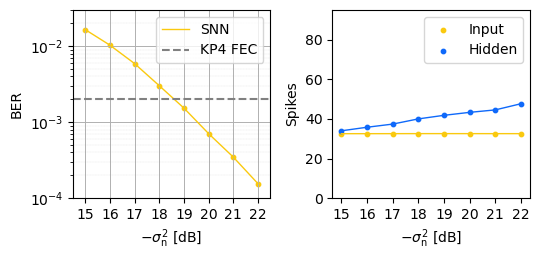

In [15]:
data = np.load("./imdd-task/example_results_final/LCD/snr/test_bers.npy")

fig, axs = plt.subplots(ncols=2, figsize=(5.5, 2.7))

axs[0].set_ylabel("BER")
axs[0].set_xlabel("$-\sigma^2_\mathrm{n}$ [dB]")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4, 3e-2)
axs[0].set_xlim(14.5, 22.5)
axs[0].grid(which="minor", lw=0.2, ls=":")
axs[0].grid(which="major", lw=0.7)
axs[0].set_xticks(data[:, 0])
axs[0].set_yticks([1e-4, 1e-3, 1e-2])
axs[0].plot(data[:, 0], data[:, 1], lw=1, color=color[0], label=r"SNN")
axs[0].scatter(data[:, 0], data[:, 1], color=color[0], s=10)
axs[0].hlines(2e-3, 14.5, 22.5, color="grey", ls="--", label="KP4 FEC")
axs[0].legend()

axs[1].set_ylabel("Spikes")
axs[1].set_xlabel("$-\sigma^2_\mathrm{n}$ [dB]")
axs[1].set_xticks(data[:, 0])
axs[1].set_ylim(0, 95)
axs[1].plot(data[:, 0], data[:, 3], lw=1, color=color[0])
axs[1].scatter(data[:, 0], data[:, 3], color=color[0], s=10, label="Input")
axs[1].plot(data[:, 0], data[:, 4], lw=1, color=color[2])
axs[1].scatter(data[:, 0], data[:, 4], color=color[2], s=10, label="Hidden")
axs[1].legend()

plt.tight_layout()
plt.savefig(data_dir / "ber_snr.png")

## 2000 bit error events are enough

In [28]:
# We rerun the testing for 10 different seeds
bers = torch.zeros(10)

for seed in range(10):
    # Dataset and loader
    dataset = LCDDataset(seed=seed)
    # Set SNR in dataset
    dataset.set_noise_power_db(-20.)
    
    # Dataloader
    test_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # Load best model for current SNR
    state_dict = torch.load(model_dir / "snr_20.pt")
    lif_demapper.load_state_dict(state_dict)
    lif_demapper.eval()

    # Test
    ber, _, h_rate, n_false = test(test_loader, lif_demapper, device, min_false_bits)
    bers[seed] = ber.cpu()
    
    print(f"Tested Demapper for Seed {seed}. BER = {ber}, n_false = {n_false}, rate = {h_rate}")
    
np.save(data_dir / "test_bers_20dB.npy", bers)

print(f"BER = {bers.mean()} +- {bers.std()}")

Tested Demapper for Seed 0. BER = 0.0007367646903730929, n_false = 2004, rate = 43.30912780761719
Tested Demapper for Seed 1. BER = 0.0007271739304997027, n_false = 2007, rate = 43.30989074707031
Tested Demapper for Seed 2. BER = 0.0007174999336712062, n_false = 2009, rate = 43.295738220214844
Tested Demapper for Seed 3. BER = 0.0007095744367688894, n_false = 2001, rate = 43.3001823425293
Tested Demapper for Seed 4. BER = 0.0007462962530553341, n_false = 2015, rate = 43.30105972290039
Tested Demapper for Seed 5. BER = 0.0007286231848411262, n_false = 2011, rate = 43.32617950439453
Tested Demapper for Seed 6. BER = 0.0006721476675011218, n_false = 2003, rate = 43.293724060058594
Tested Demapper for Seed 7. BER = 0.0007127659046091139, n_false = 2010, rate = 43.268558502197266
Tested Demapper for Seed 8. BER = 0.0007066901307553053, n_false = 2007, rate = 43.29539108276367
Tested Demapper for Seed 9. BER = 0.0006986111402511597, n_false = 2012, rate = 43.29408645629883
BER = 0.0007156146

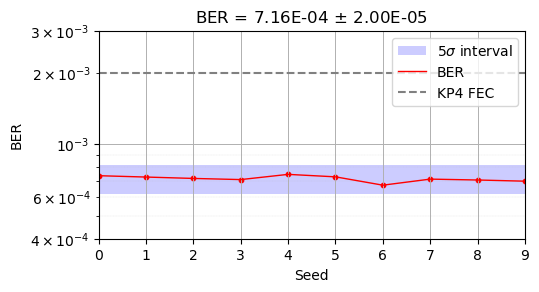

In [30]:
data = np.load(data_dir / "test_bers_20dB.npy")

fig, axs = plt.subplots(ncols=1, figsize=(5.5, 2.7))
axs.set_ylabel("BER")
axs.set_xlabel("Seed")
axs.set_yscale("log")
axs.set_ylim(4e-4, 3e-3)
axs.set_xlim(0, 9)
axs.grid(which="minor", lw=0.2, ls=":")
axs.grid(which="major", lw=0.7)
axs.set_xticks(np.arange(10))
axs.set_yticks([4e-4, 1e-3, 3e-3])
axs.fill_between(
    np.arange(10),
    np.full(10, data.mean()) - 5 * data.std(),
    np.full(10, data.mean()) + 5 * data.std(), lw=1, facecolor="blue", alpha=0.2, label=r"$5\sigma$ interval")
axs.plot(np.arange(10), data, lw=1, color="red", label=r"BER")
axs.scatter(np.arange(10), data, color="red", s=10)
axs.hlines(2e-3, 0, 9, color="grey", ls="--", label="KP4 FEC")
axs.set_title(f"BER = {data.mean():.2E} $\pm$ {data.std():.2E}")
axs.legend()

## Sweep Hidden Size as -20dB

Now we repeat the procedure but instead we keep the noise level constant at required value and sweep the number of neurons in the hidden layer. 

In [16]:
# Train demapper on independet data
data_dir = Path("./imdd-task/example_results_final/LCD/hidden_size")
data_dir.mkdir(exist_ok=True, parents=True)
model_dir = data_dir / "models"
model_dir.mkdir(exist_ok=True, parents=True)

### Train

In [32]:
for n_hidden in [5, 10, 15, 20, 30, 40, 60, 100]:
    print(f"n_hidden: {n_hidden}")

    # reset seed
    torch.manual_seed(0)
    np.random.seed(0)

    lif_demapper = SNNDemapper(
        n_in=70,  # n_taps * n_reference_points
        n_hidden=n_hidden,
        n_out=4,  # len(alphabet)
        encoder=encoder,
        lif_params=norse.LIFParameters(
            tau_mem_inv=1/6e-3,
            tau_syn_inv=1/6e-3,
            v_leak=0.,
            v_reset=0.,
            v_th=1.),
        li_params=norse.LIParameters(
            tau_mem_inv=torch.tensor(1/6e-3).to(device),
            tau_syn_inv=torch.tensor(1/6e-3).to(device),
            v_leak=torch.tensor(0.)),
        dt=dt,
        device=device)

    # Dataset
    dataset = LCDDataset()

    # Dataloader
    train_loader = torch.utils.data.DataLoader(dataset, batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # We pre train at lower noise levels
    for i, snr in enumerate(torch.tensor([30, 22, 21, 20])):
        print(f"SNR: {snr.item()}")
        # update SNR in Dataset
        dataset.set_noise_power_db(-snr.item())

        # New scheduler
        optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

        # train for SNR
        best_val_ber = np.inf
        for epoch in range(epochs):
            train_loss, train_acc, train_ber = train(
                train_loader, optimizer, scheduler, loss_fn, lif_demapper, device)
            if (epoch + 1) % 10 == 0 and epoch > 0 and snr == 20.:
                val_loss, val_acc, val_ber, n_false = validate(
                    val_loader, lif_demapper, loss_fn, device, min_false_bits,
                    max_test_epochs)

                # Save best Demapper
                if val_ber < best_val_ber:
                    torch.save(
                        lif_demapper.state_dict(), model_dir / f"n_hidden_{n_hidden}.pt")
                    best_val_ber = val_ber

                print(f"Epoch={epoch}, val_loss={val_loss:.4f}, "
                    + f"val_ber={val_ber:.7f}, val_acc={val_acc:.4f}, "
                    + f"n_false={n_false}")

n_hidden: 5
SNR: 30


### Test

In [17]:
# Test demapper on independent data for different hidden sizes
datas = np.zeros((8, 5))

for s, n_hidden in enumerate([5, 10, 15, 20, 30, 40, 60, 100]):

    lif_demapper = SNNDemapper(
        n_in=70,  # n_taps * n_reference_points
        n_hidden=n_hidden,
        n_out=4,  # len(alphabet)
        encoder=encoder,
        lif_params=norse.LIFParameters(
            tau_mem_inv=1/6e-3,
            tau_syn_inv=1/6e-3,
            v_leak=0.,
            v_reset=0.,
            v_th=1.),
        li_params=norse.LIParameters(
            tau_mem_inv=torch.tensor(1/6e-3).to(device),
            tau_syn_inv=torch.tensor(1/6e-3).to(device),
            v_leak=torch.tensor(0.)),
        dt=dt,
        device=device)

    # Dataset and loader
    dataset = LCDDataset(train=False)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # Load best model for current SNR
    state_dict = torch.load(model_dir / f"n_hidden_{n_hidden}.pt")
    lif_demapper.load_state_dict(state_dict)

    ber, i_rate, h_rate, n_false = test(test_loader, lif_demapper, device, min_false_bits)
    datas[s] = torch.tensor([n_hidden, ber, n_false, i_rate, h_rate]).cpu().numpy()

    print(f"Tested Demapper for {n_hidden}. BER = {ber}, n_false = {n_false}, rate = {h_rate}")

    np.save(data_dir / "test_bers.npy", datas)

Tested Demapper for 5. BER = 0.0014357143081724644, n_false = 2010, rate = 14.206411361694336
Tested Demapper for 10. BER = 0.001086956588551402, n_false = 2000, rate = 19.566696166992188
Tested Demapper for 15. BER = 0.0009500000160187483, n_false = 2014, rate = 23.167034149169922
Tested Demapper for 20. BER = 0.0009031531517393887, n_false = 2005, rate = 29.505449295043945
Tested Demapper for 30. BER = 0.0008108870242722332, n_false = 2011, rate = 36.55928421020508
Tested Demapper for 40. BER = 0.0007300724973902106, n_false = 2015, rate = 43.08424758911133
Tested Demapper for 60. BER = 0.0006734899361617863, n_false = 2007, rate = 56.64339065551758
Tested Demapper for 100. BER = 0.0006295596831478179, n_false = 2002, rate = 87.08405303955078


### Plot BER-Hidden Size Curve

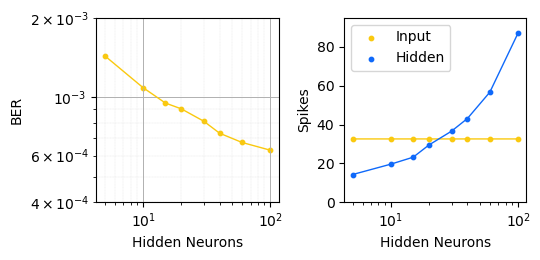

In [18]:
data = np.load(data_dir / "test_bers.npy")

fig, axs = plt.subplots(ncols=2, figsize=(5.5, 2.7))

axs[0].set_ylabel("BER")
axs[0].set_xlabel("Hidden Neurons")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].grid(which="minor", lw=0.2, ls=":")
axs[0].grid(which="major", lw=0.7)
axs[0].plot(data[:, 0], data[:, 1], lw=1, color=color[0])
axs[0].scatter(data[:, 0], data[:, 1], color=color[0], s=10)
axs[0].set_ylim(4e-4, 2e-3)

axs[1].set_ylabel("Spikes")
axs[1].set_xscale("log")
axs[1].set_xlabel("Hidden Neurons")
axs[1].set_ylim(0, 95)
axs[1].plot(data[:, 0], data[:, 3], lw=1, color=color[0])
axs[1].scatter(data[:, 0], data[:, 3], color=color[0], s=10, label="Input")
axs[1].plot(data[:, 0], data[:, 4], lw=1, color=color[2])
axs[1].scatter(data[:, 0], data[:, 4], color=color[2], s=10, label="Hidden")
axs[1].legend()

plt.tight_layout()
plt.savefig(data_dir / "ber_hidden_size.png")

## Sweep $n_\text{taps}$ at -20 dB 

In [19]:
# Train demapper
data_dir = Path("./imdd-task/example_results_final/LCD/n_taps")
data_dir.mkdir(exist_ok=True, parents=True)
model_dir = data_dir / "models"
model_dir.mkdir(exist_ok=True, parents=True)

ths = [0.4, 0.7, 0.8, 1, 1, 1, 1, 1, 1]
taps = [1, 3, 5, 7, 9, 11, 13, 15, 17]

### Train

In [36]:
for v_th, n_taps in zip(ths, taps):
    print(f"n_taps: {n_taps}")

    # reset seed
    torch.manual_seed(0)
    np.random.seed(0)

    lif_demapper = SNNDemapper(
        n_in=10*n_taps,  # n_taps * n_reference_points
        n_hidden=40,
        n_out=4,  # len(alphabet)
        encoder=encoder,
        lif_params=norse.LIFParameters(
            tau_mem_inv=1/6e-3,
            tau_syn_inv=1/6e-3,
            v_leak=0.,
            v_reset=0.,
            v_th=v_th),
        li_params=norse.LIParameters(
            tau_mem_inv=torch.tensor(1/6e-3).to(device),
            tau_syn_inv=torch.tensor(1/6e-3).to(device),
            v_leak=torch.tensor(0.)),
        dt=dt,
        device=device)

    # Dataset
    dataset = LCDDataset()
    dataset.set_n_taps(n_taps)

    # Dataloader
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        dataset, batch_size_val, shuffle=True)

    for i, snr in enumerate(torch.tensor([30, 22, 21, 20])):
        print(f"SNR: {snr.item()}")
        # update SNR in Dataset
        dataset.set_noise_power_db(-snr.item())

        # New scheduler
        optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=10, gamma=0.9)

        # train for SNR
        best_val_ber = np.inf
        for epoch in range(epochs):
            train_loss, train_acc, train_ber = train(
                train_loader, optimizer, scheduler, loss_fn, lif_demapper,
                device)
            if (epoch + 1) % 10 == 0 and epoch > 0 and snr == 20.:
                val_loss, val_acc, val_ber, n_false = validate(
                    val_loader, lif_demapper, loss_fn, device, min_false_bits, max_test_epochs)

                # Save best Demapper
                if val_ber < best_val_ber:
                    torch.save(lif_demapper.state_dict(), model_dir / f"n_taps_{n_taps}.pt")
                    best_val_ber = val_ber

                print(f"Epoch={epoch}, val_loss={val_loss:.4f}, "
                    + f"val_ber={val_ber:.7f}, val_acc={val_acc:.4f}, "
                    + f"n_false={n_false}")

n_taps: 1
SNR: 30
SNR: 22
SNR: 21
SNR: 20
Epoch=9, val_loss=0.0771, val_ber=0.0145071, val_acc=0.9710, n_false=2031
Epoch=19, val_loss=0.0791, val_ber=0.0149286, val_acc=0.9701, n_false=2090
Epoch=29, val_loss=0.0772, val_ber=0.0144643, val_acc=0.9711, n_false=2025
Epoch=39, val_loss=0.0787, val_ber=0.0153000, val_acc=0.9694, n_false=2142
Epoch=49, val_loss=0.0786, val_ber=0.0143929, val_acc=0.9712, n_false=2015
Epoch=59, val_loss=0.0777, val_ber=0.0148429, val_acc=0.9703, n_false=2078
Epoch=69, val_loss=0.0771, val_ber=0.0147786, val_acc=0.9704, n_false=2069
Epoch=79, val_loss=0.0805, val_ber=0.0150429, val_acc=0.9699, n_false=2106
Epoch=89, val_loss=0.0786, val_ber=0.0150214, val_acc=0.9700, n_false=2103
Epoch=99, val_loss=0.0787, val_ber=0.0145357, val_acc=0.9709, n_false=2035
n_taps: 3
SNR: 30
SNR: 22
SNR: 21
SNR: 20
Epoch=9, val_loss=0.0109, val_ber=0.0016949, val_acc=0.9966, n_false=2000
Epoch=19, val_loss=0.0103, val_ber=0.0016323, val_acc=0.9967, n_false=2024
Epoch=29, val_loss

### Test

In [20]:
# Test demapper on independent data for different n_taps
datas = np.zeros((9, 5))

for s, (v_th, n_taps) in enumerate(zip(ths, taps)):
    lif_demapper = SNNDemapper(
        n_in=10 * n_taps,  # n_taps * n_reference_points
        n_hidden=40,
        n_out=4,  # len(alphabet)
        encoder=encoder,
        lif_params=norse.LIFParameters(
            tau_mem_inv=1/6e-3,
            tau_syn_inv=1/6e-3,
            v_leak=0.,
            v_reset=0.,
            v_th=v_th),
        li_params=norse.LIParameters(
            tau_mem_inv=torch.tensor(1/6e-3).to(device),
            tau_syn_inv=torch.tensor(1/6e-3).to(device),
            v_leak=torch.tensor(0.)),
        dt=dt,
        device=device)

    # Dataset and loader
    dataset = LCDDataset(train=False)
    dataset.set_n_taps(n_taps)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # Load best model for current SNR
    state_dict = torch.load(model_dir / f"n_taps_{n_taps}.pt")
    lif_demapper.load_state_dict(state_dict)
    
    ber, i_rate, h_rate, n_false = test(test_loader, lif_demapper, device, min_false_bits)
    datas[s] = torch.tensor([n_taps, ber, n_false, i_rate, h_rate]).cpu().numpy()

    print(f"Tested Demapper for n_taps = {n_taps}. BER = {ber}, n_false = {n_false}, rate = {h_rate}")

    np.save(data_dir / "test_bers.npy", datas)

Tested Demapper for n_taps = 1. BER = 0.013312499970197678, n_false = 2130, rate = 26.186487197875977
Tested Demapper for n_taps = 3. BER = 0.001537121250294149, n_false = 2029, rate = 45.798187255859375
Tested Demapper for n_taps = 5. BER = 0.0008760869386605918, n_false = 2015, rate = 44.00190353393555
Tested Demapper for n_taps = 7. BER = 0.0007753846002742648, n_false = 2016, rate = 43.3635368347168
Tested Demapper for n_taps = 9. BER = 0.0007010489352978766, n_false = 2005, rate = 45.501319885253906
Tested Demapper for n_taps = 11. BER = 0.0007095744367688894, n_false = 2001, rate = 46.801151275634766
Tested Demapper for n_taps = 13. BER = 0.0006900000153109431, n_false = 2001, rate = 47.63945388793945
Tested Demapper for n_taps = 15. BER = 0.0007134751067496836, n_false = 2012, rate = 50.93803405761719
Tested Demapper for n_taps = 17. BER = 0.0007208632887341082, n_false = 2004, rate = 48.675315856933594


### Plot $n_\text{taps}$-BER Curve

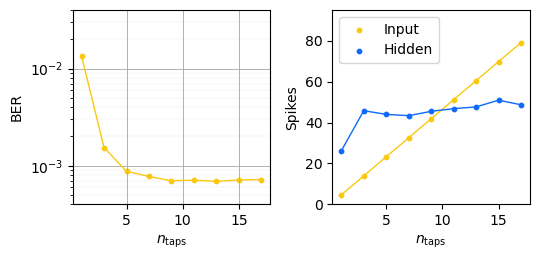

In [21]:
data = np.load(data_dir / "test_bers.npy")

fig, axs = plt.subplots(ncols=2, figsize=(5.5, 2.7))

axs[0].set_ylabel("BER")
axs[0].set_yticks([1e-3, 5e-4])
axs[0].set_xlabel("$n_\mathrm{taps}$")
axs[0].set_ylim(4e-4, 4e-2)
axs[0].set_yscale("log")
axs[0].grid(which="minor", lw=0.2, ls=":")
axs[0].grid(which="major", lw=0.7)
axs[0].plot(data[:, 0], data[:, 1], lw=1, color=color[0])
axs[0].scatter(data[:, 0], data[:, 1], color=color[0], s=10)

axs[1].set_ylabel("Spikes")
axs[1].set_xlabel("$n_\mathrm{taps}$")
axs[1].set_ylim(0, 95)
axs[1].plot(data[:, 0], data[:, 3], lw=1, color=color[0])
axs[1].scatter(data[:, 0], data[:, 3], color=color[0], s=10, label="Input")
axs[1].plot(data[:, 0], data[:, 4], lw=1, color=color[2])
axs[1].scatter(data[:, 0], data[:, 4], color=color[2], s=10, label="Hidden")
axs[1].legend()

plt.tight_layout()
plt.savefig(data_dir / "n_taps_ber.png")